In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(degrees=5),
  transforms.RandomCrop(32,4),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
trainset = torchvision.datasets.CIFAR100('./data',train=True,download=False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True,num_workers=4)
testset = torchvision.datasets.CIFAR100('./data',train=True,download=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=128, shuffle=False,num_workers=4)
classes = testset.classes



In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
    self.pool2 = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(128*8*8,256)
    self.fc2 = nn.Linear(256,100)
  
  def forward(self,x):
    x = f.relu(self.conv1(x))
    x = f.relu(self.conv2(x))
    x = self.pool1(x)
    x = f.relu(self.conv3(x))
    x = f.relu(self.conv4(x))
    x = self.pool2(x)
    x = x.view(x.size(0),-1)
    x = f.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)


In [9]:
train_acc_list, test_acc_list = [], []
num_epochs = 10

for epoch in range(num_epochs):
    net.train()
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)

    # Test Accuracy
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Accuracy: {train_acc:.2f}% | Test Accuracy: {test_acc:.2f}%")


Epoch 1/10 | Train Accuracy: 46.64% | Test Accuracy: 47.26%
Epoch 2/10 | Train Accuracy: 47.31% | Test Accuracy: 50.14%
Epoch 3/10 | Train Accuracy: 48.33% | Test Accuracy: 48.60%
Epoch 4/10 | Train Accuracy: 49.29% | Test Accuracy: 50.80%
Epoch 5/10 | Train Accuracy: 50.07% | Test Accuracy: 51.40%
Epoch 6/10 | Train Accuracy: 51.04% | Test Accuracy: 52.64%
Epoch 7/10 | Train Accuracy: 51.61% | Test Accuracy: 52.40%
Epoch 8/10 | Train Accuracy: 52.25% | Test Accuracy: 53.45%
Epoch 9/10 | Train Accuracy: 52.89% | Test Accuracy: 55.05%
Epoch 10/10 | Train Accuracy: 53.65% | Test Accuracy: 54.07%


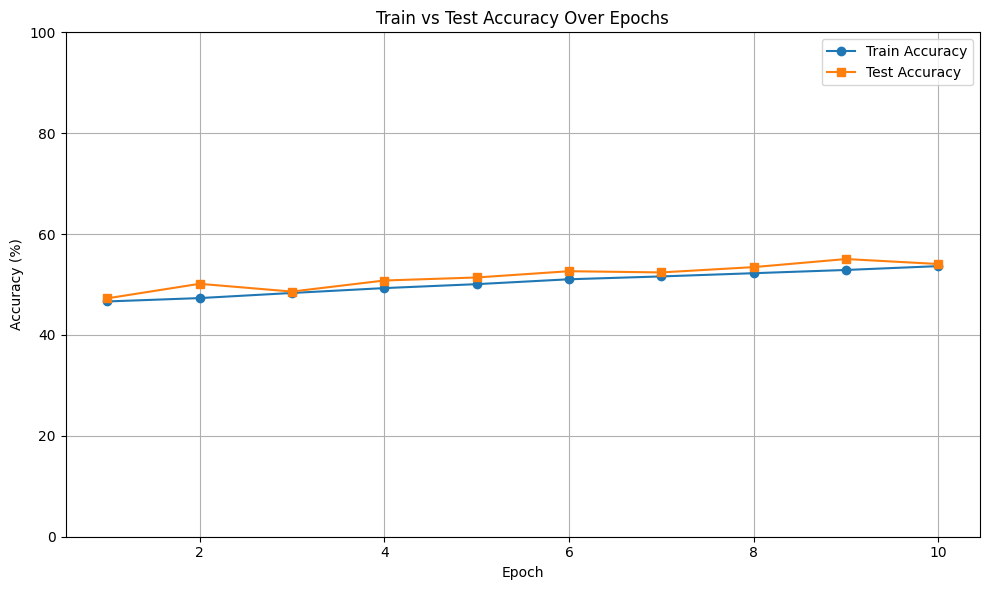

In [10]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_acc_list, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc_list, label='Test Accuracy', marker='s')

plt.title('Train vs Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
from PIL import Image
# Load image
image = Image.open("image.png").convert('RGB')  # ensures it's 3-channel

# Define CIFAR-100 transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # ensures size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),  # CIFAR mean
                         (0.5, 0.5, 0.5))  # CIFAR std
])

# Apply transform and move to device
input_tensor = transform(image).unsqueeze(0).to(device)

# Set model to eval mode and predict
net.eval()
with torch.no_grad():
    outputs = net(input_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()

# Get class name
classes = trainset.classes
print(f"Predicted class: {classes[predicted_class]}")

Predicted class: train
